## Testing Pytesseract library in different use cases

Three cases have been studied to apply the utilities of the Pytesseract Library. The cases are:

- Image with flat text
- Image with simple table
- Image with complex table

For each example there are shown input images and output text.

https://fazlurnucom.wordpress.com/2020/06/23/text-extraction-from-a-table-image-using-pytesseract-and-opencv/

In [1]:
import PIL
import IPython
import pandas as pd
import pytesseract
import numpy as np
import cv2

from matplotlib import pyplot as plt

In [2]:
#
pytesseract.pytesseract.tesseract_cmd = "C:/Users/shiru/anaconda3/envs/gputf/Library/bin/tesseract.exe"

### 1. image with flat text

In [3]:
img1 = r'../data/flat_text.png'

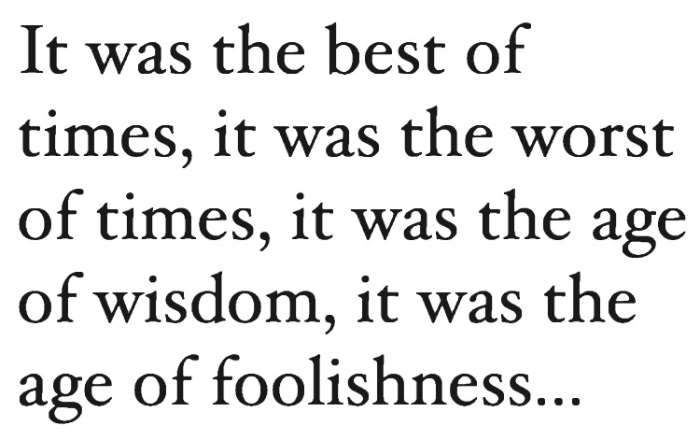

In [4]:
IPython.display.Image(filename=img1) 

In [5]:
# Simple image to string
print(pytesseract.image_to_string(PIL.Image.open(img1), lang = 'eng'))

It was the best of
times, it was the worst
of times, it was the age
of wisdom, it was the
age of foolishness...



### 2. image with simple table

In [18]:
path_img2 = '../data/simple_table_text.png'

#Variables defining the table
n_rows = 5
n_columns = 2

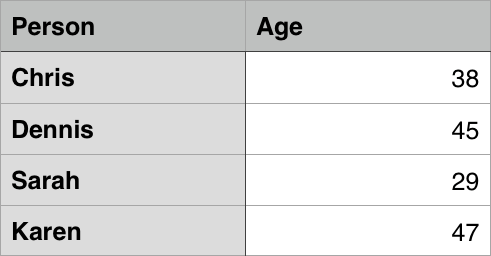

In [13]:
IPython.display.Image(filename=path_img2) 

In [15]:
#Threshold for better results
img2 = cv2.imread(path_img2)
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

In [16]:
# Simple image to string. Introducing the image with vertical and horizontal lines
print(pytesseract.image_to_string(gray, lang = 'eng'))

Person Age

Chris 38
Dennis 45
Sarah 29
Karen 47



In [20]:
#Visualizing the string result
text2 = pytesseract.image_to_string(gray, lang = 'eng')
text2

'Person Age\n\nChris 38\nDennis 45\nSarah 29\nKaren 47\n'

In [40]:
#Make ad-hoc solution for this table image
df_list = [item.split(' ') for item in text2.split('\n') if len(item.split(' ')) == n_columns]
df_list

[['Person', 'Age'],
 ['Chris', '38'],
 ['Dennis', '45'],
 ['Sarah', '29'],
 ['Karen', '47']]

In [43]:
#Creating dataframe to simulate the table
df_img2 = pd.DataFrame(df_list)
df_img2.columns = df_img2.iloc[0]
df_img2 = df_img2[1:]
df_img2

,Person,Age
1,Chris,38
2,Dennis,45
3,Sarah,29
4,Karen,47


#### Same case deleting horizontal and vertical lines

In [45]:
# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ( int(np.round(gray.shape[1]*0.7)) , 1))
                                              
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, (0,0,0), 2)
    
cv2.imshow('thresh', thresh)
cv2.waitKey()

-1

In [47]:
# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(np.round(gray.shape[0]*0.7)) ))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, (0,0,0), 3)
    
cv2.imshow('thresh', thresh)
cv2.waitKey()

-1

In [50]:
text2 = pytesseract.image_to_string(thresh, lang = 'eng')
print(text2)

Person Age
Chris

Dennis

Sarah

Karen

38
45
29
47



In [51]:
text2

'Person Age\nChris\n\nDennis\n\nSarah\n\nKaren\n\n38\n45\n29\n47\n'

#### Conclusions

In both cases the final solutions are 

### 3. image with complex table

In [53]:
path_image3 = '../data/complex_table_text.png'

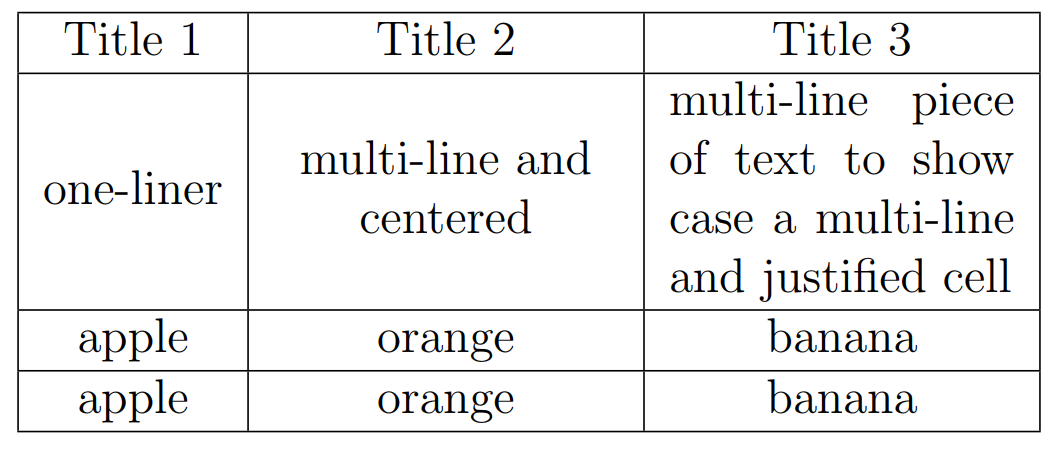

In [54]:
IPython.display.Image(filename=path_image3)

In [81]:
# Load image, grayscale, and Otsu's threshold
image3 = cv2.imread(path_image3)
gray = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cImage = np.copy(image3) 

cv2.imshow('thresh', thresh)
cv2.waitKey()

-1

In [82]:
theta = np.pi/180
rho = 1
threshold = 50
minLinLength = int(np.round(gray.shape[0]*0.8))
maxLineGap = 6

linesP = cv2.HoughLinesP(thresh, rho , theta, threshold, None, minLinLength, maxLineGap)

In [83]:
linesP

array([[[  17,  309, 1040,  309]],

       [[  17,  431, 1040,  431]],

       [[  17,  370, 1040,  370]],

       [[  17,  371, 1040,  371]],

       [[  17,   12, 1040,   12]],

       [[  17,   72, 1040,   72]],

       [[  17,   73, 1040,   73]],

       [[  17,  310, 1040,  310]],

       [[ 247,  430,  247,   13]],

       [[ 643,  430,  643,   13]],

       [[ 248,  430,  248,   13]],

       [[  17,  430,   17,   13]],

       [[1039,  430, 1039,   13]],

       [[ 644,  430,  644,   13]],

       [[1040,  430, 1040,   13]],

       [[  18,  430,   18,   13]]], dtype=int32)

In [84]:
def overlapping_filter(lines, sorting_index):
    filtered_lines = []
    
    lines = sorted(lines, key=lambda lines: lines[sorting_index])
    separation = 5    
    
    for i in range(len(lines)):
            l_curr = lines[i]
            if(i>0):
                l_prev = lines[i-1]
                if ( (l_curr[sorting_index] - l_prev[sorting_index]) > separation):
                    filtered_lines.append(l_curr)
            else:
                filtered_lines.append(l_curr)
                
    return filtered_lines

In [85]:
def is_vertical(line):
    return line[0]==line[2]

def is_horizontal(line):
    return line[1]==line[3]

horizontal_lines = []
vertical_lines = []
    
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]        
        if (is_vertical(l)):
            vertical_lines.append(l)
                
        elif (is_horizontal(l)):
            horizontal_lines.append(l)
            
horizontal_lines = overlapping_filter(horizontal_lines, 1)
vertical_lines = overlapping_filter(vertical_lines, 0)
            
for i, line in enumerate(horizontal_lines):
    cv2.line(cImage, (line[0], line[1]), (line[2], line[3]), (0,255,0), 3, cv2.LINE_AA)
                      
for i, line in enumerate(vertical_lines):
    cv2.line(cImage, (line[0], line[1]), (line[2], line[3]), (0,0,255), 3, cv2.LINE_AA)
            
cv2.imshow("with_line", cImage)
cv2.waitKey(0)

-1

In [86]:
vertical_lines

[array([ 17, 430,  17,  13], dtype=int32),
 array([247, 430, 247,  13], dtype=int32),
 array([643, 430, 643,  13], dtype=int32),
 array([1039,  430, 1039,   13], dtype=int32)]

In [87]:
horizontal_lines

[array([  17,   12, 1040,   12], dtype=int32),
 array([  17,   72, 1040,   72], dtype=int32),
 array([  17,  309, 1040,  309], dtype=int32),
 array([  17,  370, 1040,  370], dtype=int32),
 array([  17,  431, 1040,  431], dtype=int32)]

In [88]:
def get_cropped_image(image, x, y, w, h):
    cropped_image = image[ y:y+h , x:x+w ]
    return cropped_image

def get_ROI(image, horizontal, vertical, left_line_index, right_line_index, top_line_index, bottom_line_index, offset=4):
    x1 = vertical[left_line_index][2] + offset
    y1 = horizontal[top_line_index][3] + offset
    x2 = vertical[right_line_index][2] - offset
    y2 = horizontal[bottom_line_index][3] - offset
    
    w = x2 - x1
    h = y2 - y1
    
    cropped_image = get_cropped_image(image, x1, y1, w, h)
    
    return cropped_image, (x1, y1, w, h)

In [89]:
def detect(cropped_frame):
    
    text = pytesseract.image_to_string(cropped_frame)
    return text

In [115]:
## set line index
n_rows = 4
n_columns = 3

columns = list(range(n_rows-1))

dict_df = {}
for keyword in columns:
    dict_df[keyword] = []

Start detecting text...


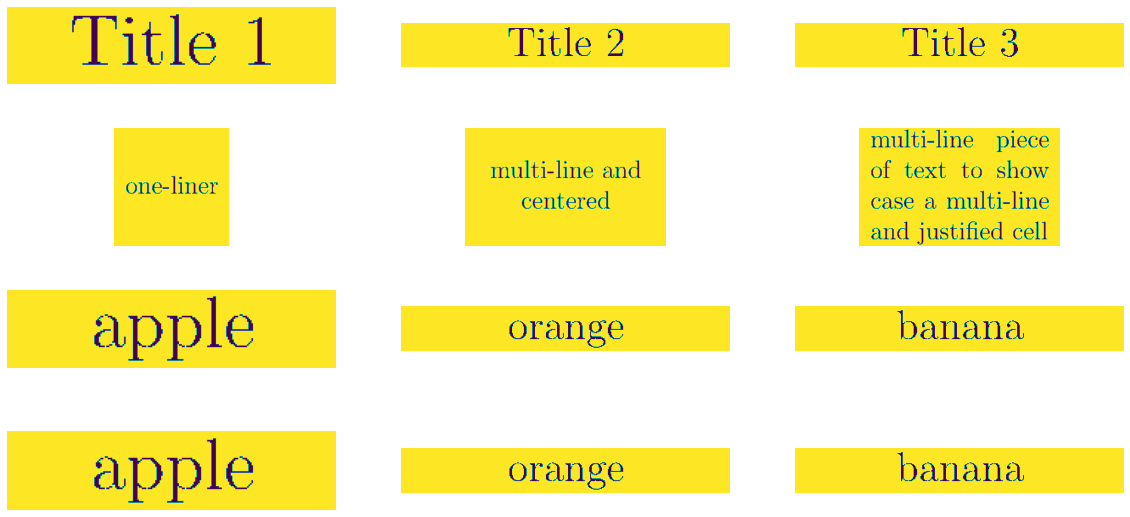

In [132]:
print("Start detecting text...")

(thresh, bw) = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize = (20,10))
count = 0

for i in range(n_rows):
    
    for j, keyword in enumerate(columns):
        
        count += 1
        left_line_index = j
        right_line_index = j+1
        top_line_index = i
        bottom_line_index = i+1
            
        cropped_image, (x,y,w,h) = get_ROI(bw, horizontal_lines, vertical_lines, left_line_index, right_line_index, 
                                           top_line_index, bottom_line_index)
        
        plt.subplot(n_rows, n_columns, count)
        plt.imshow(cropped_image)
        plt.axis('off')
        
        text = detect(cropped_image)
        dict_df[keyword].append(text)
        
plt.show()

In [109]:
dict_df

{'0': ['Title 1\n', 'one-liner\n', 'apple\n', 'apple\n'],
 '1': ['Title 2\n', 'multi-line and\ncentered\n', 'orange\n', 'orange\n'],
 '2': ['Title 3\n',
  'multi-line piece\nof text to show\ncase a multi-line\nand justified cell\n',
  'banana\n',
  'banana\n']}

In [110]:
df = pd.DataFrame(dict_df)
df = df.replace('\n', '', regex=True)
df.columns = df.iloc[0]
df = df[1:]
df

,Title 1,Title 2,Title 3
1,one-liner,multi-line andcentered,multi-line pieceof text to showcase a multi-li...
2,apple,orange,banana
3,apple,orange,banana
